In [21]:
from aimacode.search import (breadth_first_search, astar_search,
    breadth_first_tree_search, depth_first_graph_search, uniform_cost_search,
    greedy_best_first_graph_search, depth_limited_search,
    recursive_best_first_search)
from air_cargo_problems import air_cargo_p1, air_cargo_p2, air_cargo_p3, air_cargo_p4

from _utils import run_search, PrintableProblem
from timeit import default_timer as timer

import pandas as pd
import dask
from dask import delayed
import dask.multiprocessing
from dask.diagnostics import ProgressBar
from copy import deepcopy
import pickle

from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline

PROBLEMS = [
            ["Air Cargo Problem 1", air_cargo_p1],
            ["Air Cargo Problem 2", air_cargo_p2],
            ["Air Cargo Problem 3", air_cargo_p3],
            ["Air Cargo Problem 4", air_cargo_p4]
           ]
SEARCHES = [
            ["breadth_first_search", breadth_first_search, ""],
            ['depth_first_graph_search', depth_first_graph_search, ""],
            ['uniform_cost_search', uniform_cost_search, ""],
            ['greedy_best_first_graph_search', greedy_best_first_graph_search, 'h_unmet_goals'],
            ['greedy_best_first_graph_search', greedy_best_first_graph_search, 'h_pg_levelsum'],
            ['greedy_best_first_graph_search', greedy_best_first_graph_search, 'h_pg_maxlevel'],
            ['greedy_best_first_graph_search', greedy_best_first_graph_search, 'h_pg_setlevel'],
            ['astar_search', astar_search, 'h_unmet_goals'],
            ['astar_search', astar_search, 'h_pg_levelsum'],
            ['astar_search', astar_search, 'h_pg_maxlevel'],
            ['astar_search', astar_search, 'h_pg_setlevel']
           ]

In [2]:
# p_choices = [1, 2]
p_choices = list(range(1, len(PROBLEMS) + 1))
# s_choices = [1, 2]
s_choices = list(range(1, len(SEARCHES) + 1))

In [3]:
problems = [PROBLEMS[i-1] for i in map(int, p_choices)]
searches = [SEARCHES[i-1] for i in map(int, s_choices)]

In [4]:
results = {}

In [5]:
def run_get_results(problem, search):
    pname, problem_fn = problem
    sname, search_fn, heuristic = search
    hstring = heuristic if not heuristic else f" with {heuristic}"

    problem_instance = problem_fn()
    heuristic_fn = None if not heuristic else getattr(problem_instance, heuristic)
    ip = PrintableProblem(problem_instance)
    start = timer()
    if heuristic_fn is not None:
        node = search_fn(ip, heuristic_fn)
    else:
        node = search_fn(ip)
    end = timer()
    print(f"Finished {pname} using {sname}{hstring} in {end - start:.2}s")
    if heuristic_fn is None:
        return {
            pname: {
                sname: {
                    '# Actions': len(ip.problem.actions_list),
                    'Expansions': ip.succs,
                    'Goal Tests': ip.goal_tests,
                    'New Nodes': ip.states,
                    'Plan Length': len(node.solution()),
                    'Time Elapsed (s)': end - start,
                    'Planned Actions': [f'{action.name}{action.args}' for action in node.solution()]
                }
            }
        }
    else:
        return {
            pname: {
                f'{sname}{hstring}': {
                    '# Actions': len(ip.problem.actions_list),
                    'Expansions': ip.succs,
                    'Goal Tests': ip.goal_tests,
                    'New Nodes': ip.states,
                    'Plan Length': len(node.solution()),
                    'Time Elapsed (s)': end - start,
                    'Planned Actions': [f'{action.name}{action.args}' for action in node.solution()]
                }
            }
        }
    

In [6]:
dask_tasks = []
for p in problems:
    for s in searches:
        dask_tasks.append(delayed(run_get_results)(p, s))

In [7]:
with ProgressBar(), dask.set_options(get=dask.multiprocessing.get):
    dask_returns = dask.compute(*dask_tasks, num_workers=10)

/home/rluo/anaconda3/envs/aind/lib/python3.6/site-packages/dask/context.py:23: UserWarning: The dask.set_options function has been deprecated. Please use dask.config.set instead
  warnings.warn("The dask.set_options function has been deprecated. "
/home/rluo/anaconda3/envs/aind/lib/python3.6/site-packages/dask/base.py:828: UserWarning: The get= keyword has been deprecated. Please use the scheduler= keyword instead with the name of the desired scheduler like 'threads' or 'processes'
  warnings.warn("The get= keyword has been deprecated. "


[                                        ] | 0% Completed |  0.0sFinished Air Cargo Problem 1 using greedy_best_first_graph_search with h_unmet_goals in 0.0014s
Finished Air Cargo Problem 1 using breadth_first_search in 0.012s
Finished Air Cargo Problem 1 using uniform_cost_search in 0.018s
[##                                      ] | 6% Completed |  0.3sFinished Air Cargo Problem 1 using greedy_best_first_graph_search with h_pg_maxlevel in 0.29s
[###                                     ] | 9% Completed |  1.0sFinished Air Cargo Problem 1 using astar_search with h_pg_levelsum in 1.0s
Finished Air Cargo Problem 3 using greedy_best_first_graph_search with h_unmet_goals in 0.047s
[#####                                   ] | 13% Completed |  3.7sFinished Air Cargo Problem 2 using astar_search with h_unmet_goals in 2.6s
[######                                  ] | 15% Completed |  8.1sFinished Air Cargo Problem 2 using greedy_best_first_graph_search with h_pg_levelsum in 8.1s
[#######      

In [8]:
for res in dask_returns:
    ks = list(res.keys())
    k = ks[0]
    if len(ks) > 1:
        print("ERROR!")
        break
    if not k in results:
        results.update(res)
    else:
        results[k].update(res[k])

In [10]:
with open('results.pkl', 'wb') as results_pkl:
    pickle.dump(results, results_pkl, protocol=4)

In [6]:
with open('results.pkl', 'rb') as results_pkl:
    results = pickle.load(results_pkl)

In [7]:
[len(results[k]) for k in results]

[11, 11, 11, 11]

In [8]:
results_df = deepcopy(results)

In [9]:
for p in results_df:
    for s in results_df[p]:
        results_df[p][s] = pd.DataFrame.from_dict(results_df[p][s], orient='index').T
        results_df[p][s].loc[:, 'search'] = s

In [10]:
for p in results_df:
    results_df[p] = pd.concat([results_df[p][s] for s in results_df[p]])
    results_df[p].loc[:, 'problem'] = p

In [11]:
results_df = pd.concat([results_df[p] for p in results_df])

In [12]:
results_df.loc[:, 'problem_num'] = results_df['problem'].apply(lambda x: x[-1]).astype('float')

In [16]:
metrics = ['# Actions', 'Expansions', 'Goal Tests', 'New Nodes', 'Plan Length', 'Time Elapsed (s)']

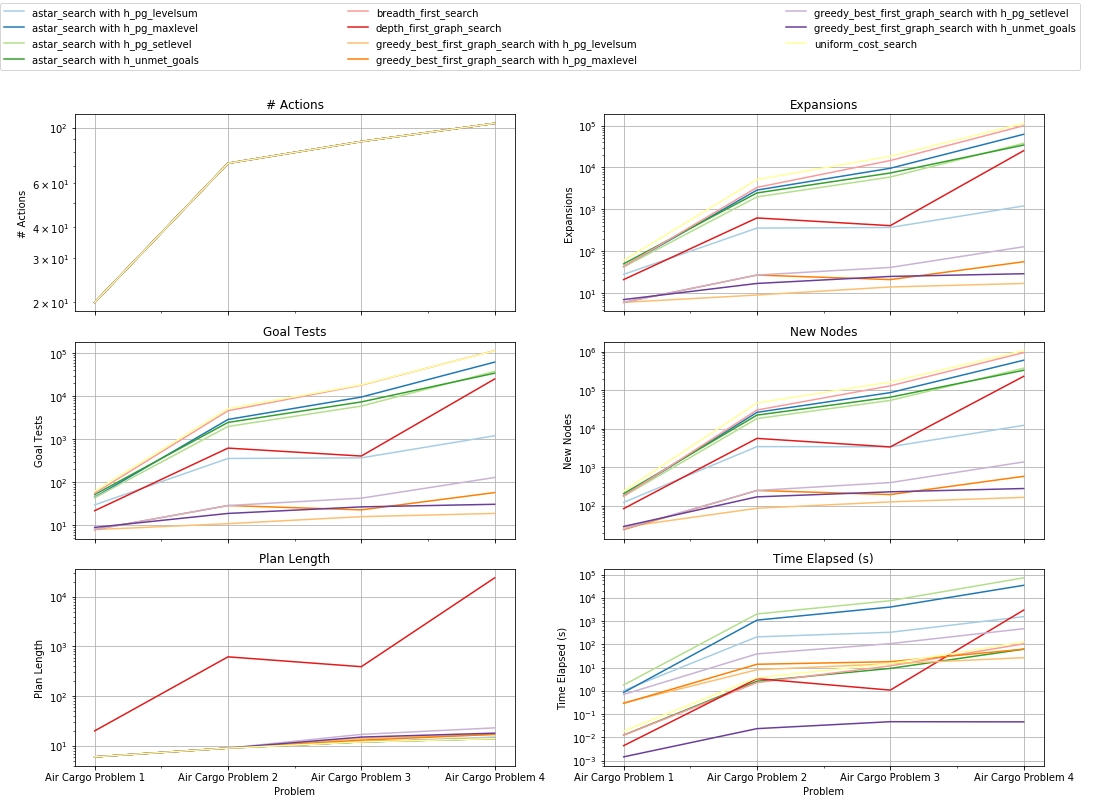

In [69]:
search_names = sorted(results_df.search.drop_duplicates())
cmap = cm.Paired(range(len(search_names)))
colors = {search_names[i]: cmap[i] for i in range(len(search_names))}

fig, axes=plt.subplots(nrows=3, ncols=2, figsize=(15, 10), sharex=True)
for i in range(len(metrics)):
    metric = metrics[i]
    ax = axes[i//2, i%2]
    for title, group in results_df.groupby('search'):
        group.plot(x='problem_num', y=metric, label=title, ax=ax, logy=True, c=colors[title])
    ax.set_xticks([1, 2, 3, 4])
    ax.set_xticklabels([
        "Air Cargo Problem 1",
        "Air Cargo Problem 2",
        "Air Cargo Problem 3",
        "Air Cargo Problem 4"])
    ax.set_title(metric)
    ax.set_xlabel('Problem')
    ax.set_ylabel(metric)
    ax.grid()
    ax.legend().set_visible(False)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=3, mode="expand", borderaxespad=0.)

plt.tight_layout()
plt.savefig(f'./results.png')

# Generate report pics

In [71]:
metrics

['# Actions',
 'Expansions',
 'Goal Tests',
 'New Nodes',
 'Plan Length',
 'Time Elapsed (s)']

In [163]:
figsize = (7, 3)
bbox_to_anchor = (1.02, -0.2, 0.7, 0.5)

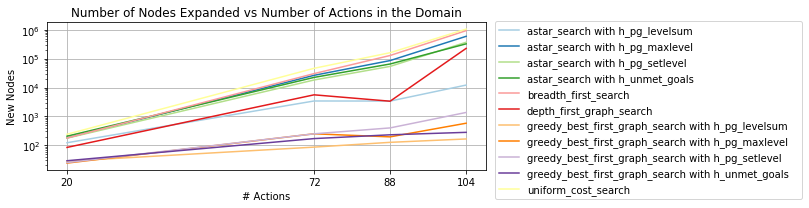

In [164]:
fig, ax=plt.subplots(figsize=figsize)
metric = 'New Nodes'
for title, group in results_df.groupby('search'):
    group.plot(x='# Actions', y=metric, label=title, ax=ax, logy=True, c=colors[title])
ax.set_xticks([20, 72, 88, 104])
ax.set_xticklabels([20, 72, 88, 104])
ax.set_title(metric)
ax.set_xlabel('# Actions')
ax.set_ylabel(metric)
ax.grid()
ax.legend().set_visible(False)
ax.set_title('Number of Nodes Expanded vs Number of Actions in the Domain')

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, bbox_to_anchor=bbox_to_anchor, loc=3,
       ncol=1, mode="expand", borderaxespad=0.)

plt.tight_layout()
plt.savefig(f'./n_actions_vs_n_nodes.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

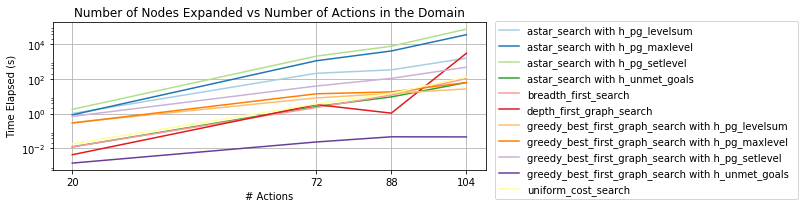

In [166]:
fig, ax=plt.subplots(figsize=figsize)
metric = 'Time Elapsed (s)'
for title, group in results_df.groupby('search'):
    group.plot(x='# Actions', y=metric, label=title, ax=ax, logy=True, c=colors[title])
ax.set_xticks([20, 72, 88, 104])
ax.set_xticklabels([20, 72, 88, 104])
ax.set_title(metric)
ax.set_xlabel('# Actions')
ax.set_ylabel(metric)
ax.grid()
ax.legend().set_visible(False)
ax.set_title('Number of Nodes Expanded vs Number of Actions in the Domain')

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, bbox_to_anchor=bbox_to_anchor, loc=3,
       ncol=1, mode="expand", borderaxespad=0.)

plt.tight_layout()
plt.savefig(f'./n_actions_vs_time.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

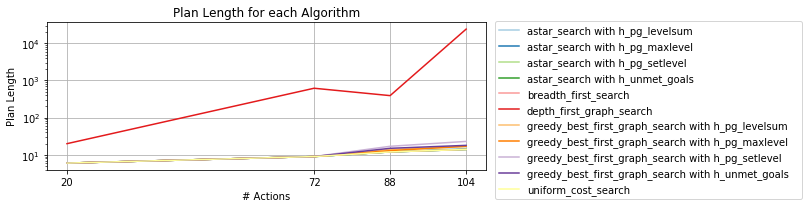

In [167]:
fig, ax=plt.subplots(figsize=figsize)
metric = 'Plan Length'
for title, group in results_df.groupby('search'):
    group.plot(x='# Actions', y=metric, label=title, ax=ax, logy=True, c=colors[title])
ax.set_xticks([20, 72, 88, 104])
ax.set_xticklabels([20, 72, 88, 104])
ax.set_title(metric)
ax.set_xlabel('# Actions')
ax.set_ylabel(metric)
ax.grid()
ax.legend().set_visible(False)
ax.set_title('Plan Length for each Algorithm')

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, bbox_to_anchor=bbox_to_anchor, loc=3,
       ncol=1, mode="expand", borderaxespad=0.)

plt.tight_layout()
plt.savefig(f'./plan_length.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

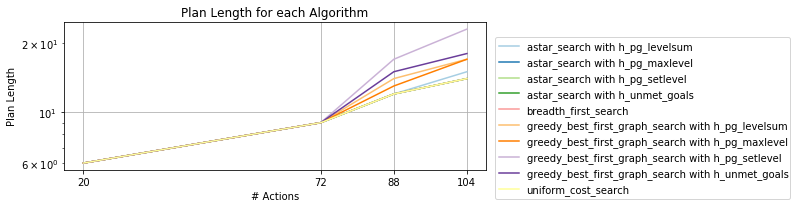

In [190]:
fig, ax=plt.subplots(figsize=figsize)
metric = 'Plan Length'
for title, group in results_df.groupby('search'):
    if title != 'depth_first_graph_search':
        group.plot(x='# Actions', y=metric, label=title, ax=ax, logy=True, c=colors[title])
ax.set_xticks([20, 72, 88, 104])
ax.set_xticklabels([20, 72, 88, 104])
ax.set_title(metric)
ax.set_xlabel('# Actions')
ax.set_ylabel(metric)
ax.grid()
ax.legend().set_visible(False)
ax.set_title('Plan Length for each Algorithm')

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, bbox_to_anchor=bbox_to_anchor, loc=3,
       ncol=1, mode="expand", borderaxespad=0.)

plt.tight_layout()
plt.savefig(f'./plan_length_no_dfs.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [169]:
results_df

,# Actions,Expansions,Goal Tests,New Nodes,Plan Length,Time Elapsed (s),Planned Actions,search,problem,problem_num
0,20,43,56,178,6,0.0122939,"[Load(C1, P1, SFO), Load(C2, P2, JFK), Fly(P2,...",breadth_first_search,Air Cargo Problem 1,1.0
0,20,21,22,84,20,0.00434401,"[Fly(P1, SFO, JFK), Fly(P2, JFK, SFO), Load(C2...",depth_first_graph_search,Air Cargo Problem 1,1.0
0,20,60,62,240,6,0.0184052,"[Load(C2, P2, JFK), Fly(P2, JFK, SFO), Load(C1...",uniform_cost_search,Air Cargo Problem 1,1.0
0,20,7,9,29,6,0.00143652,"[Load(C1, P1, SFO), Load(C2, P2, JFK), Fly(P2,...",greedy_best_first_graph_search with h_unmet_goals,Air Cargo Problem 1,1.0
0,20,6,8,28,6,0.302826,"[Load(C1, P1, SFO), Fly(P1, SFO, JFK), Unload(...",greedy_best_first_graph_search with h_pg_levelsum,Air Cargo Problem 1,1.0
0,20,6,8,24,6,0.289642,"[Load(C1, P1, SFO), Load(C2, P2, JFK), Fly(P2,...",greedy_best_first_graph_search with h_pg_maxlevel,Air Cargo Problem 1,1.0
0,20,6,8,25,6,0.694699,"[Load(C1, P1, SFO), Fly(P1, SFO, JFK), Load(C2...",greedy_best_first_graph_search with h_pg_setlevel,Air Cargo Problem 1,1.0
0,20,50,52,206,6,0.0123561,"[Load(C2, P2, JFK), Fly(P2, JFK, SFO), Unload(...",astar_search with h_unmet_goals,Air Cargo Problem 1,1.0
0,20,28,30,122,6,1.02207,"[Load(C2, P2, JFK), Fly(P2, JFK, SFO), Unload(...",astar_search with h_pg_levelsum,Air Cargo Problem 1,1.0
0,20,43,45,180,6,0.85002,"[Load(C2, P2, JFK), Fly(P2, JFK, SFO), Load(C1...",astar_search with h_pg_maxlevel,Air Cargo Problem 1,1.0
